**About Dataset**

* Context

  The whole world is suffering from COVID-19 disease and its proper and timely diagnosis is the need of the hour. So for building an efficient AI-based diagnostic system we have collected Chest ray images from different sources so that we can train our CNN model for automating the whole diagnosis method. Therefore we have collected Chest ray images from different sources and research papers and combined them to create one comprehensive dataset that can be used by research community.

  This dataset is also used in COVID Lite paper which has shown significant results by building novel CNN based solution.

* Content

  This dataset consists of a posteroanterior (PA) view of chest X-ray images comprising Normal, Viral, and CVOID-19 affected patients. There are total 1709 CXR images.

# **Load Data**

In [1]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shutil
import os
import shutil
from tqdm import tqdm
import glob as gb

import tensorflow as tf
import keras
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers, Model
from keras.models import Sequential, Model
from keras.layers import *

2024-03-29 11:26:07.662132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 11:26:07.662323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 11:26:07.837054: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Exploration**

In [2]:
data_dir = '/kaggle/input/covid-19-chest-x-ray/Data/'

In [3]:
data = pd.read_csv('/kaggle/input/covid-19-chest-x-ray/Data.csv')
data

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal
...,...,...
1191,118777221.jpeg,virus
1192,375945707.jpeg,normal
1193,531745860.jpeg,virus
1194,121544623.jpeg,covid


In [4]:
data['Label'].value_counts()

Label
normal    468
virus     433
covid     295
Name: count, dtype: int64

In [5]:
px.histogram(data, y="Label", color="Label", title="Classes Distribution")

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


* **Covid Class Being Less Present than others.**

In [6]:
Classes = ['covid', 'normal', 'virus']

In [7]:
def Plot_Classes(BASE_URL, Rows=2, Columns=5):

  """
  Plot a Random Image of Each Class in Train/Test Folder.
  """

  plt.figure(figsize = (25, 8))

  image_count = 1

  for directory in os.listdir(BASE_URL):

      if directory[0] != '.':

          Max_Random = len(os.listdir(os.path.join(BASE_URL,directory)))

          Random_Number = np.random.randint(0, Max_Random)

          for i, file in enumerate(os.listdir(BASE_URL + directory)):

              if i == Random_Number:

                  fig = plt.subplot(Rows, Columns, image_count)
                  image_count += 1

                  image = plt.imread(BASE_URL + directory + '/' + file)
                  plt.imshow(image)

                  plt.title(directory)

                  break

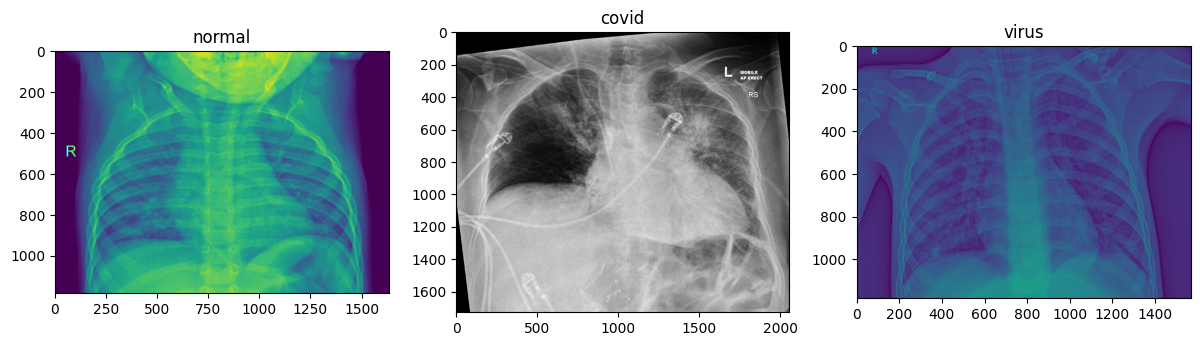

In [8]:
Plot_Classes(data_dir)

In [9]:
size = []
for folder in  os.listdir(data_dir) :
    files_je = gb.glob(pathname= str( data_dir + folder + '/*.jpeg'))
    files_jp = gb.glob(pathname= str( data_dir + folder + '/*.jpg'))
    files_pn = gb.glob(pathname= str( data_dir + folder + '/*.png'))
    files = files_je + files_jp + files_pn
    for file in files:
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

(480, 640, 3)      136
(480, 640)          16
(480, 640, 4)       12
(842, 1024, 3)       6
(1024, 1024, 3)      3
                  ... 
(1761, 1845)         1
(1387, 1770)         1
(1638, 1724)         1
(1380, 1558)         1
(872, 1296)          1
Name: count, Length: 1007, dtype: int64

(480, 640, 3)


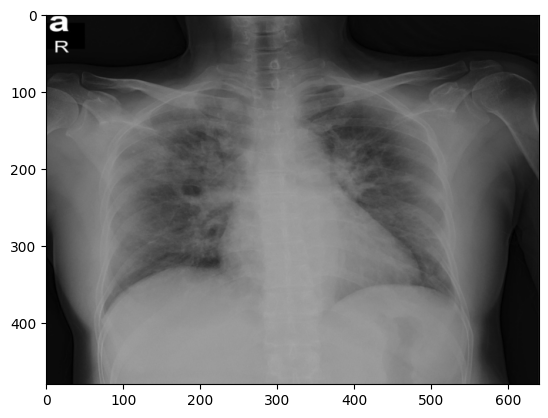

In [10]:
covidImg = plt.imread('/kaggle/input/covid-19-chest-x-ray/Data/covid/100126173.png')
print(covidImg.shape)
plt.imshow(covidImg)

In [11]:
covidImg[0]

array([[0.05098039, 0.05098039, 0.05098039],
       [0.05098039, 0.05098039, 0.05098039],
       [0.04705882, 0.04705882, 0.04705882],
       ...,
       [0.04313726, 0.04313726, 0.04313726],
       [0.03529412, 0.03529412, 0.03529412],
       [0.10196079, 0.10196079, 0.10196079]], dtype=float32)

- **Notice that the Covid Class Images are Represented as RGB Array of Images and it's Float Type (normalized).**

(1264, 1762)


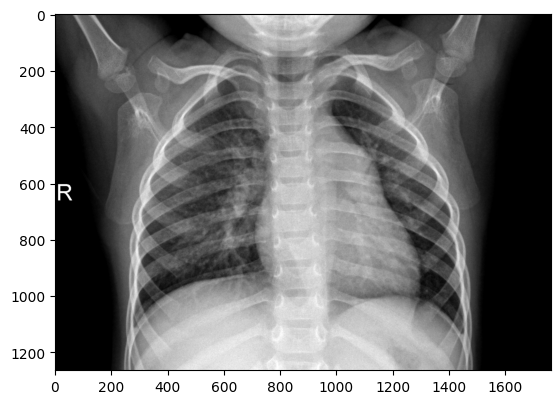

In [12]:
normalImg = plt.imread('/kaggle/input/covid-19-chest-x-ray/Data/normal/101212332.jpeg')
print(normalImg.shape)
plt.imshow(normalImg, cmap='gray')

In [13]:
normalImg[normalImg!=0]

array([41, 41, 40, ...,  3,  2,  1], dtype=uint8)

(1592, 1880)


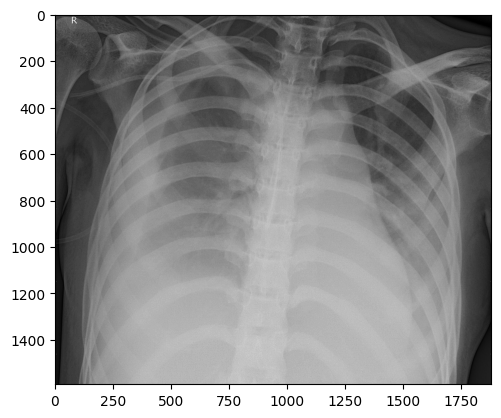

In [14]:
virusImg = plt.imread('/kaggle/input/covid-19-chest-x-ray/Data/virus/10364395.jpeg')
print(virusImg.shape)
plt.imshow(virusImg, cmap='gray')

In [15]:
virusImg[virusImg!=0]

array([67, 68, 69, ..., 39, 32, 37], dtype=uint8)

- **Unlike the other two Classes being real gray scaled images with int Types(not normalized).**

# **Data Preprocessing**

In [16]:
for index, row in data.iterrows():

  path_to_img = data_dir + row['Label'] + '/' + row['Image']

  row['Image'] = path_to_img

In [17]:
data.head()

,Image,Label
0,/kaggle/input/covid-19-chest-x-ray/Data/normal...,normal
1,/kaggle/input/covid-19-chest-x-ray/Data/virus/...,virus
2,/kaggle/input/covid-19-chest-x-ray/Data/normal...,normal
3,/kaggle/input/covid-19-chest-x-ray/Data/normal...,normal
4,/kaggle/input/covid-19-chest-x-ray/Data/normal...,normal


- **Now Let's Split the Data to Train-Test Split that have the Same Class Distribution as Original Data.**

In [18]:
x = data.drop(columns="Label")
y = data["Label"]

In [19]:
# Validation Split
x_train, x_test, y_train, y_test = train_test_split( x , y , test_size=0.15, random_state=0 )

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1016, 1)
(1016,)
(180, 1)
(180,)


In [21]:
train_df = pd.concat([x_train,y_train], axis = 1)

px.histogram(train_df, y="Label", color="Label", title="Train Classes Distribution").update_yaxes(categoryorder='total ascending')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [22]:
test_df = pd.concat([x_test,y_test], axis = 1)

px.histogram(test_df, y="Label", color="Label", title="Val Classes Distribution").update_yaxes(categoryorder='total ascending')

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



- **Notice how all the splits have the same classes distribution to the original data.**

## **Image Data Generators**




In [23]:
img_shape = 150

color_type = 3

batch_size = 32

In [24]:
train_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    seed=0
)

test_data = test_preprocessor.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col="Image",
    y_col="Label",
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    seed=0
)

Found 1016 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.


In [25]:
print("Number of Train batches:", len(train_data))
print("Number of Val batches:", len(test_data))

Number of Train batches: 32
Number of Val batches: 6


## **Checking Generators**

In [26]:
Classes_Map = train_data.class_indices

Num_Classes = len(Classes_Map)

print("Number of Classes:", Num_Classes)
Classes_Map

Number of Classes: 3


{'covid': 0, 'normal': 1, 'virus': 2}

In [27]:
train_data[0][0][0]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02745098, 0.02745098, 0.02745098]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00784314, 0.00784314, 0.00784314],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.        , 0.        , 0.        ],
        [0.        , 0

[1. 0. 0.]


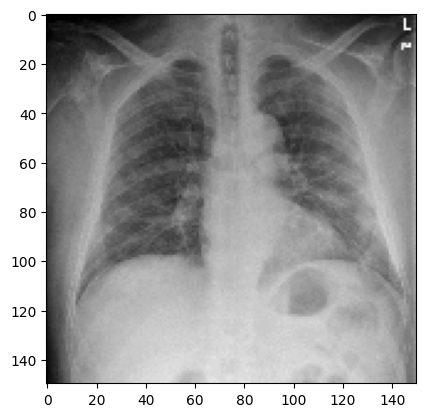

In [28]:
plt.imshow(train_data[0][0][-1])
print(train_data[0][1][-1])

In [29]:
test_data[1][0][-1]

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.03529412, 0.03529412, 0.03529412],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.05490196, 0.05490196, 0.05490196],
        [0.00784314, 0

[1. 0. 0.]


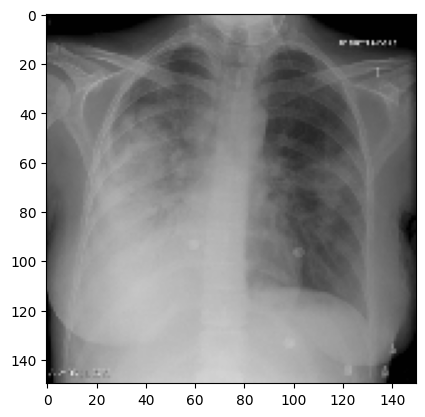

In [30]:
plt.imshow(test_data[1][0][-1])
print(test_data[1][1][-1])

- **We Notice that all the images now are represnted as gray scale float arrays (normalized images).**

# **CNN Model**

### **CNN Model Architecture**

In [31]:
def Create_CNN_Model():

    model = Sequential()

    model.add(Conv2D(32,(3,3), activation='relu', input_shape=(img_shape, img_shape, color_type)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    #Output
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense( Num_Classes , activation='softmax',input_shape=(img_shape, img_shape, color_type)))

    return model

In [32]:
cnn_model = Create_CNN_Model()

cnn_model.summary()

cnn_model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,812,995 (25.99 MB)

 Trainable params: 6,812,995 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

### **Fitting CNN Model**

In [33]:
cnn_history = cnn_model.fit(train_data , validation_data= test_data , epochs=30 , batch_size=batch_size)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4807 - loss: 1.0319 - val_accuracy: 0.7444 - val_loss: 0.7229
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7905 - loss: 0.6271 - val_accuracy: 0.8778 - val_loss: 0.3573
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8880 - loss: 0.3188 - val_accuracy: 0.8722 - val_loss: 0.2949
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9194 - loss: 0.2385 - val_accuracy: 0.9056 - val_loss: 0.2471
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9239 - loss: 0.2368 - val_accuracy: 0.9167 - val_loss: 0.2052
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9574 - loss: 0.1355 - val_accuracy: 0.9167 - val_loss: 0.2158
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9620 - loss: 0.1090 - val_accuracy: 0.9222 - val_loss: 0.1999
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9758 - loss: 0.0787 - val_accuracy: 0.9611 - val_loss: 0.0997
Epo

## **CNN Model Evaluation**

In [34]:
cnn_scores = cnn_model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(cnn_scores[0]))
print("Test Accuracy: {:.2f}%".format(cnn_scores[1] * 100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 569ms/step - accuracy: 0.9402 - loss: 0.2285
    Test Loss: 0.15636
Test Accuracy: 94.44%


In [35]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure(figsize=(15,5))
  plt.style.use('ggplot')

  #plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
  plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Val Loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
  plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Val Acc")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.style.use('default')

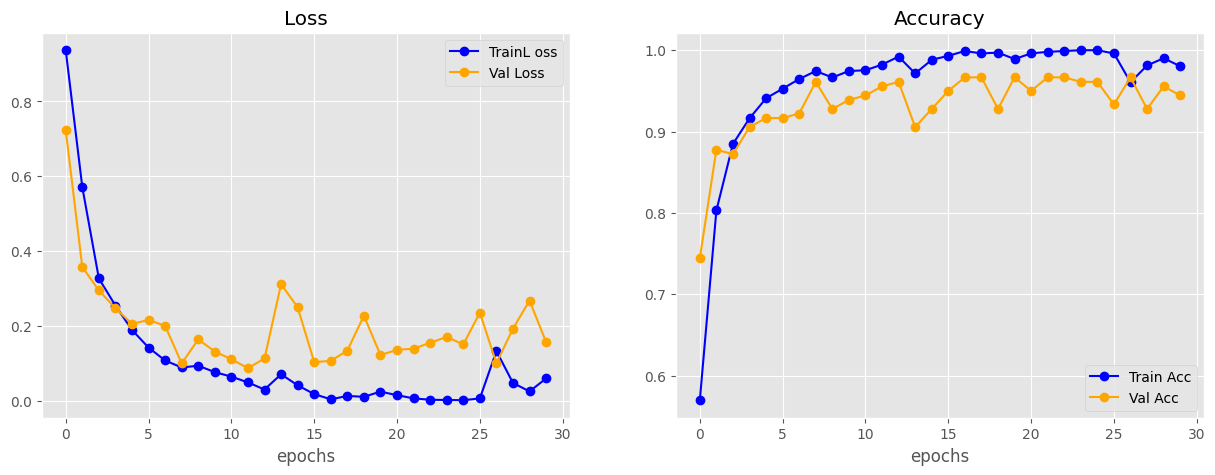

In [36]:
plot_curves(cnn_history)

In [37]:
cnn_predictions_probs = cnn_model.predict(test_data)

# Choosing highest probalbilty class in every prediction
cnn_predictions = np.argmax(cnn_predictions_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step


[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

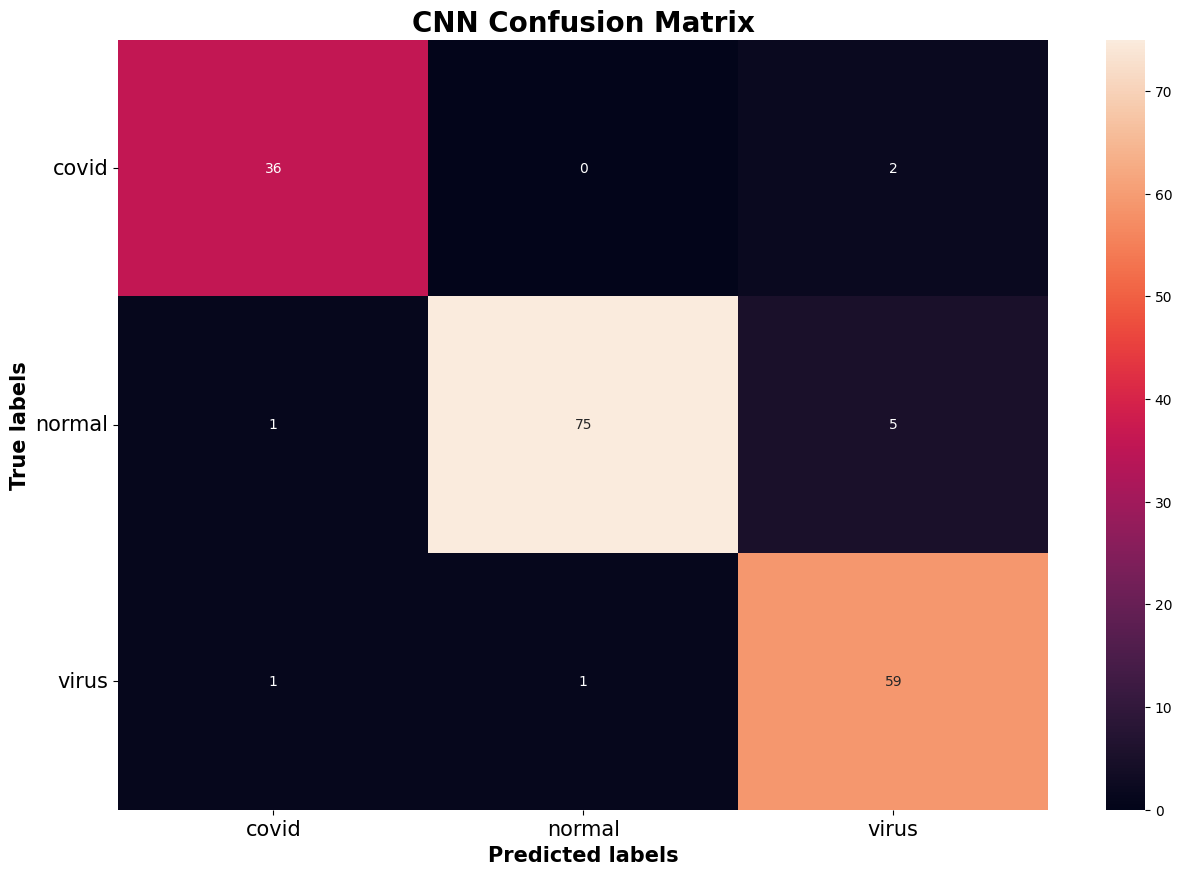

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, cnn_predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Classes , fontsize=15)
ax.set_yticklabels(Classes, rotation=0, fontsize=15)

In [39]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(test_data.labels, cnn_predictions, target_names= Classes)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       0.95      0.95      0.95        38
      normal       0.99      0.93      0.96        81
       virus       0.89      0.97      0.93        61

    accuracy                           0.94       180
   macro avg       0.94      0.95      0.94       180
weighted avg       0.95      0.94      0.94       180



In [40]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, cnn_predictions) * 100))

Test Accuracy: 94.44%


- **The Testing Accuracy after 30 Epochs was about 95%, Perhaps it would increase with more epochs but it will not be a huge increase.**

- **Transfer Learning will be useful, with more complex model architectures it will be able to achieve fit the data better.**

# **VGG-16 Model**

In [41]:
from keras.applications.vgg16 import VGG16


VGG_16 = VGG16(input_shape=(img_shape, img_shape, color_type),
              include_top= False,
              weights='imagenet',
              )

VGG_16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

#### **Freezing Layers**

In [42]:
# Freezing all layers except last 10

VGG_16.trainable = True

Trainable_Layers = 10

for layer in VGG_16.layers[ : -Trainable_Layers ]:
    layer.trainable = False

VGG_16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### **VGG-16 Model Architecture**

In [43]:
def Create_VGG16_Model():

  model = Sequential([
                      VGG_16,

                      GlobalAveragePooling2D(),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.3),

                      Dense(256, activation='relu'),
                      Dropout(0.5),

                      Dense( Num_Classes, activation='softmax')
                    ])

  return model

In [44]:
VGG16_Model = Create_VGG16_Model()

VGG16_Model.summary()

optimizer = keras.optimizers.Adam(0.0001)

VGG16_Model.compile(optimizer= optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 13,569,280 (51.76 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

### **Fitting VGG-16 Model**

In [45]:
VGG16_history = VGG16_Model.fit(train_data ,validation_data = test_data , epochs=30 , batch_size=batch_size)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 285s 9s/step - accuracy: 0.3367 - loss: 1.1401 - val_accuracy: 0.5611 - val_loss: 0.9713
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 281s 9s/step - accuracy: 0.4260 - loss: 0.9762 - val_accuracy: 0.7000 - val_loss: 0.7188
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.6109 - loss: 0.8126 - val_accuracy: 0.7056 - val_loss: 0.6659
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 325s 9s/step - accuracy: 0.6346 - loss: 0.8001 - val_accuracy: 0.7389 - val_loss: 0.5789
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 320s 9s/step - accuracy: 0.6753 - loss: 0.6419 - val_accuracy: 0.7611 - val_loss: 0.3827
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 284s 9s/step - accuracy: 0.7139 - loss: 0.4759 - val_accuracy: 0.7833 - val_loss: 0.3763
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 321s 9s/step - accuracy: 0.8189 - loss: 0.4327 - val_accuracy: 0.9333 - val_loss: 0.3180
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 280s 9s/step - accuracy: 0.9410 - loss: 0.3761 - val_accuracy: 0.9167 - v

In [46]:
VGG16_Scores = VGG16_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(VGG16_Scores[0]))
print("Test Accuracy: {:.2f}%".format(VGG16_Scores[1] * 100))

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9795 - loss: 0.3804
    Test Loss: 0.23116
Test Accuracy: 98.33%


### **VGG-16 Model Evaluation**

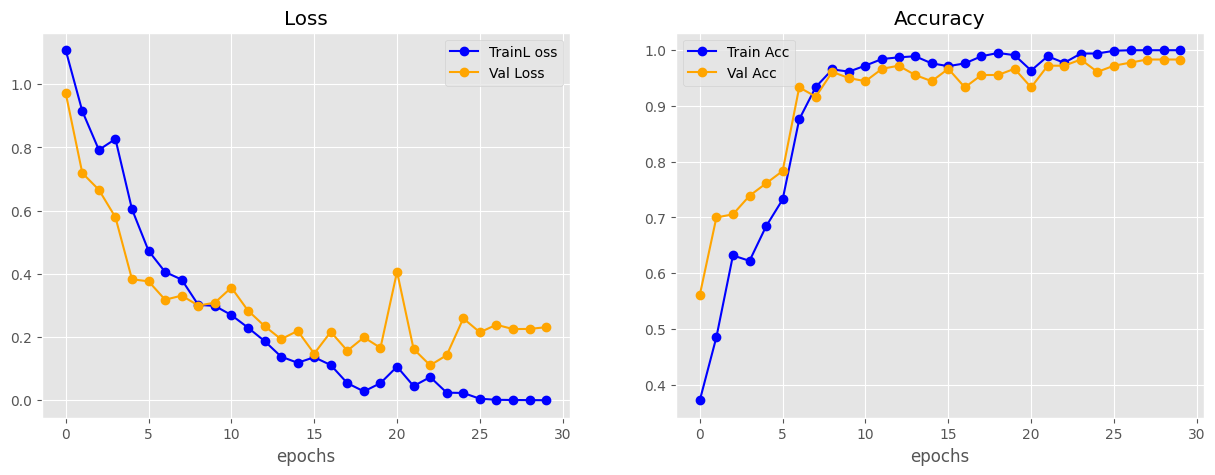

In [47]:
plot_curves(VGG16_history)

**Predicting the Test Set**

In [48]:
VGG16_Predictions_Probs = VGG16_Model.predict(test_data)

VGG16_Predictions = np.argmax(VGG16_Predictions_Probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


[Text(0, 0.5, 'covid'), Text(0, 1.5, 'normal'), Text(0, 2.5, 'virus')]

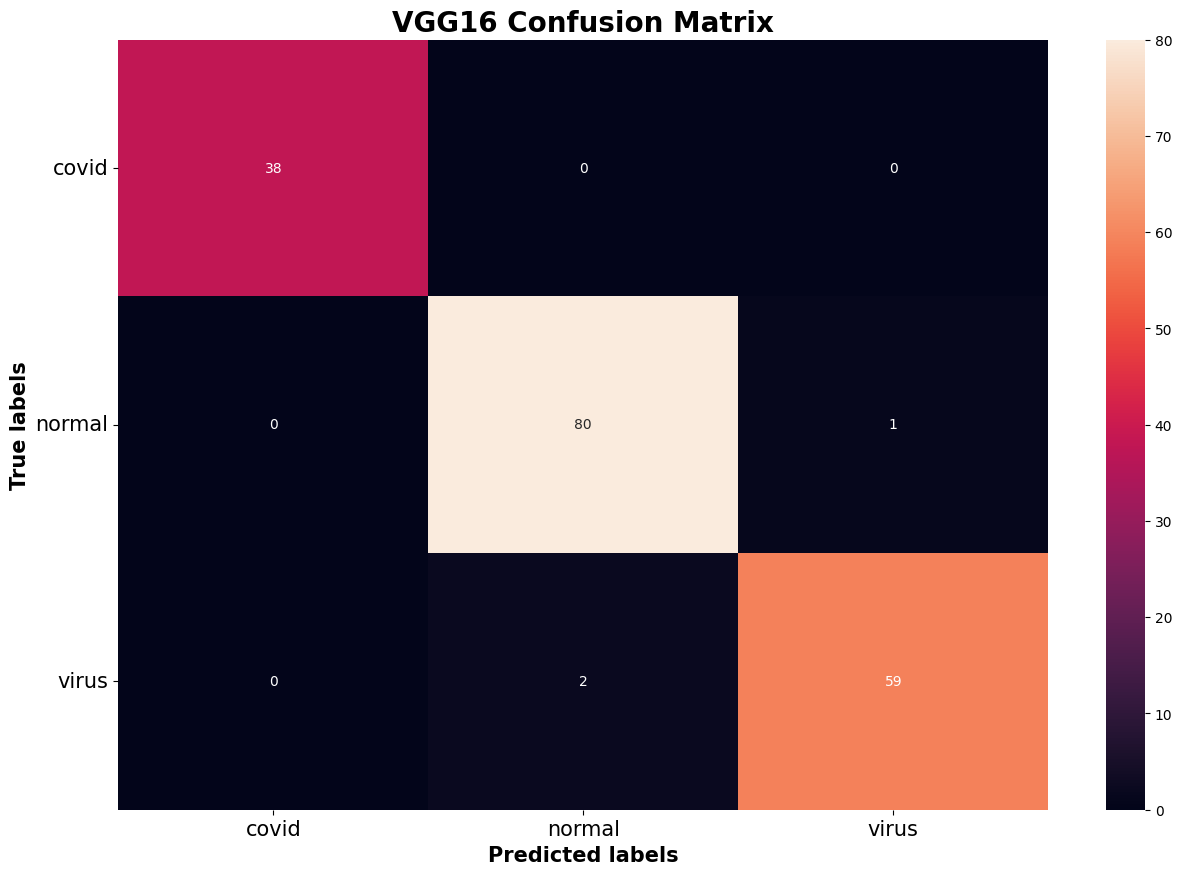

In [49]:
fig , ax= plt.subplots(figsize=(15,10))

cm = confusion_matrix(test_data.labels, VGG16_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')

ax.set_title('VGG16 Confusion Matrix', fontsize=20, fontweight='bold')

ax.set_xticklabels(Classes , fontsize=15)
ax.set_yticklabels(Classes, rotation=0, fontsize=15)

**Classification Report**

In [50]:
ClassificationReport = classification_report(test_data.labels, VGG16_Predictions, target_names= Classes)

print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

       covid       1.00      1.00      1.00        38
      normal       0.98      0.99      0.98        81
       virus       0.98      0.97      0.98        61

    accuracy                           0.98       180
   macro avg       0.99      0.98      0.99       180
weighted avg       0.98      0.98      0.98       180



In [51]:
from sklearn.metrics import accuracy_score

print("Test Accuracy: {:.2f}%".format(accuracy_score(test_data.labels, VGG16_Predictions) * 100))

Test Accuracy: 98.33%


{'covid': 0.047, 'normal': 99.604, 'virus': 0.348}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}
{'covid': 100.0, 'normal': 0.0, 'virus': 0.0}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}
{'covid': 0.0, 'normal': 0.0, 'virus': 100.0}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}
{'covid': 100.0, 'normal': 0.0, 'virus': 0.0}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}
{'covid': 0.0, 'normal': 100.0, 'virus': 0.0}


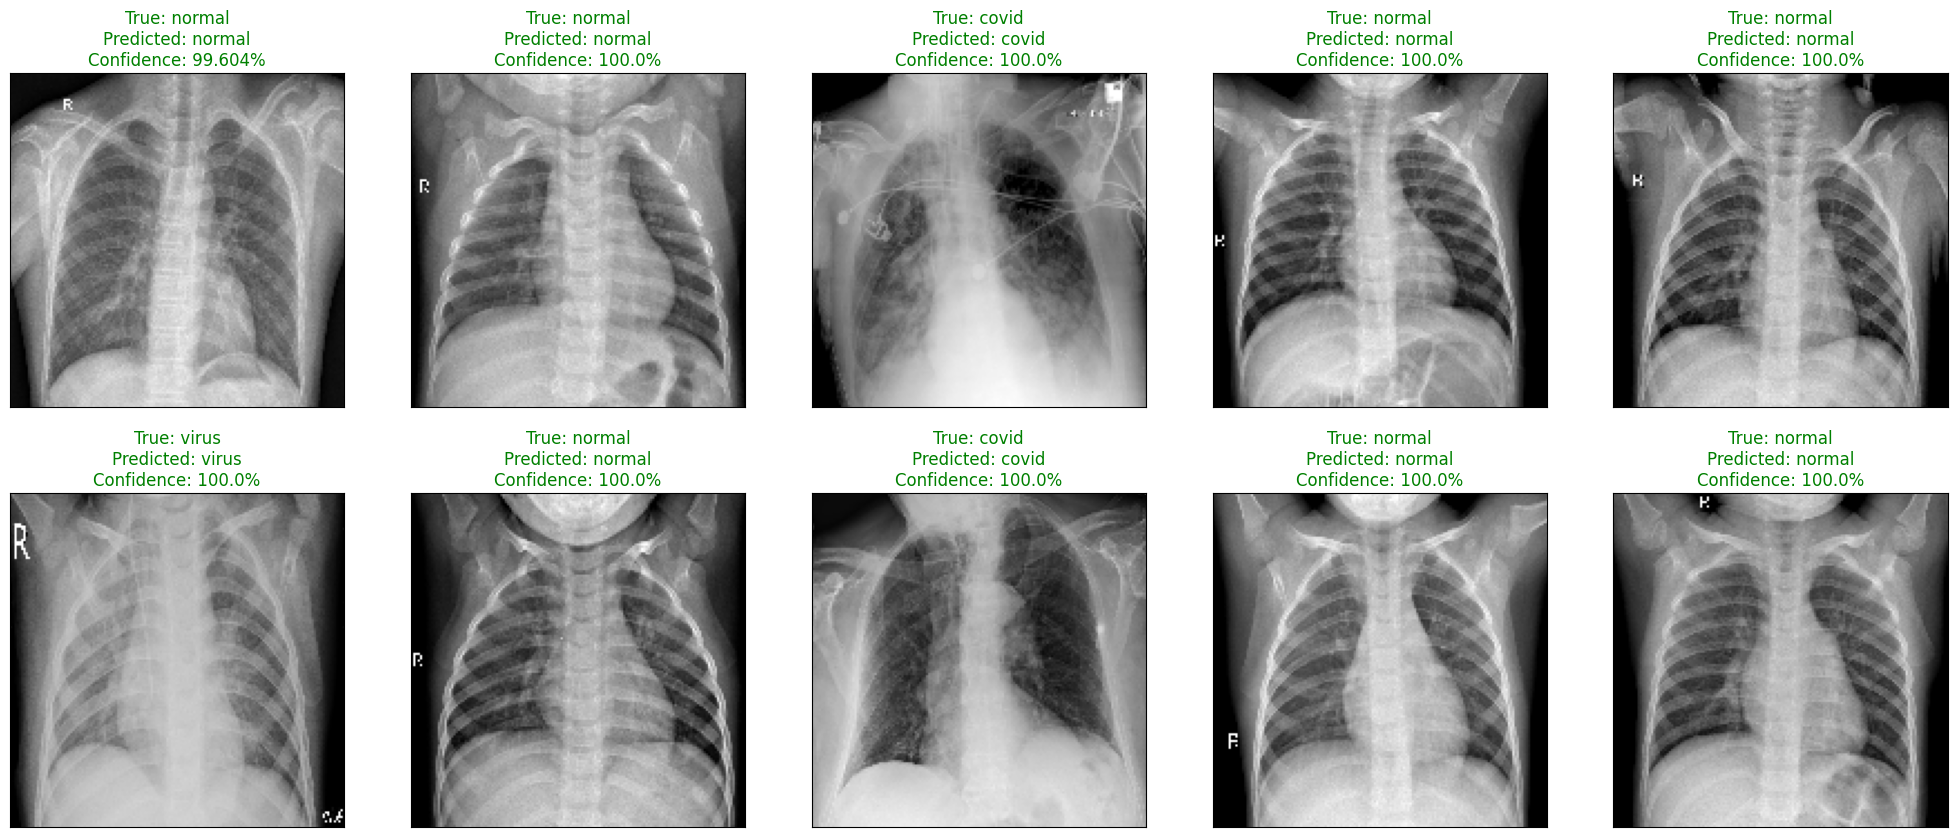

<Figure size 640x480 with 0 Axes>

In [52]:
# Display 10 random pictures predictions from the dataset with their labels

Random_batch = np.random.randint(0, len(test_data))

Random_Img_Index = np.random.randint(0, batch_size , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]])

    Model_Predictions = VGG16_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)

    Model_Highest_Prediction = np.argmax(Model_Predictions)

    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (Classes, Model_Predictions.tolist()[0] ) }

    ax.imshow(Random_Img)

    Pred_Class = Classes[Model_Highest_Prediction]

    if Classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {Classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()

* **VGG-16 Gave the Best Performance with 96.67% Accuracy and 97% F1 Score**